# Model interpretation (Estimators of the longitudinal frequencies)

In this notebook we will analyse the tuned HistGradientBoosting estimator to predict the frequency of the longitudinal mode. The residuals are calculated as the difference between the predicted and real frequencies. The SHAP tools helps us to better understand how the model predict the values.

In [90]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import seaborn as sns
import shap
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import griddata

## Load variables and target

In the first step we load the dataset, define the explanatory and target variables again:

In [2]:
# Load dataframes from binary files
fam = '03'
#base_dir = r'C:\FBr\Weiterbildung\Project'
base_dir = r'D:\Entwicklungen\share\DataScienceProject'
#base_dir = r'D:\FBr\DataScienceProject'

all_data = {}
fam_dir = os.path.join(base_dir, fam, 'data-' + fam)
all_data[fam] = {}

ft_param_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-parameters.ft')
df_params = pd.read_feather(ft_param_path)

In [3]:
lst_param = df_params.columns.to_list()

In [4]:
# Explanatory variables: all slot classes are considered, we add the 4 encoded columns to the selected dataset
lst_slot_class = lst_param[541:545]
lst_expl = lst_param[1:4] + lst_param[5:7] + lst_param[8:24] + lst_param[32:34]
# Target variable is the frequency of the longitudinal mode
target = 'freq_long'

X = df_params[lst_expl + lst_slot_class]
y = df_params[target]

In [5]:
# New Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

We define a pipeline containing the preprocessing and the tuned regressor:

## HistGradientBoosting

In [8]:
# Create the main pipeline
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

tuned_regressor = HistGradientBoostingRegressor(
                                                l2_regularization=1.0,
                                                learning_rate=0.0903,
                                                loss='gamma',
                                                max_depth=3,
                                                max_iter=1000,
                                                min_samples_leaf=85
                                                )

pipe_tuned_hist = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', tuned_regressor)
                        ])

pipe_tuned_hist.fit(X_train, y_train)
print ('Score of the test set:', pipe_tuned_hist.score(X_test, y_test))

Score of the test set: 0.9924209030658435


## Analysis of the residuals

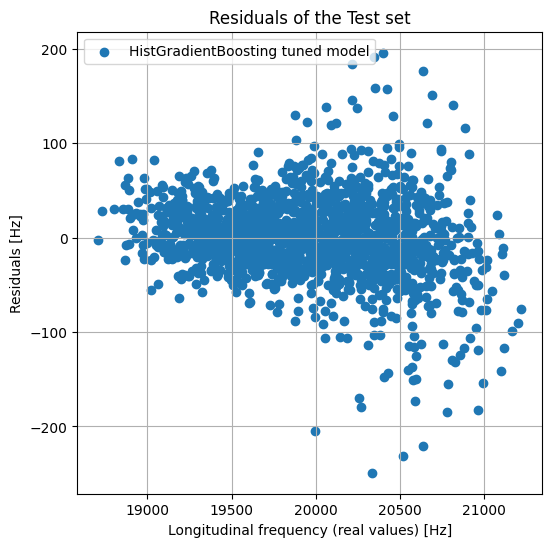

In [9]:
pipe_tuned_hist.fit(X_train, y_train)
y_pred_tuned_hist = pd.Series(pipe_tuned_hist.predict(X_test), index=y_test.index)
residuals_hist = y_pred_tuned_hist-y_test

fig = plt.figure(figsize=(6, 6))
plt.scatter(y_test, residuals_hist, label='HistGradientBoosting tuned model')
plt.xlabel('Longitudinal frequency (real values) [Hz]')
plt.ylabel('Residuals [Hz]')
plt.title('Residuals of the Test set')
plt.grid(True)
plt.legend()
plt.show()

The residual distribution seems to be centered around 0. The Q-Q plot allows us the check the normality of the distribution by comparing the distribution of the actual data with a theoretical distribution (hier a standard normal law):

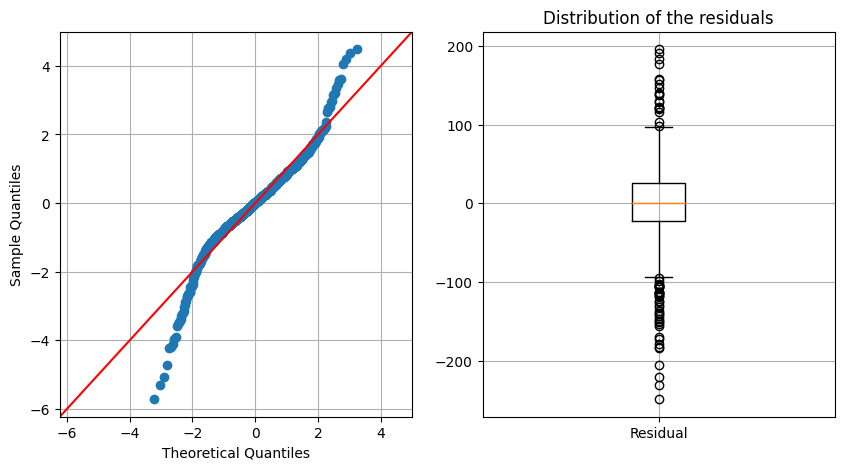

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_hist, fit=True, line='45', ax=ax)
plt.grid(True)
plt.plot

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_hist)
plt.xticks([1], ['Residual'], rotation=0)
plt.xticks([1], ['Residual'], rotation=0)
plt.grid(True)

plt.title ('Distribution of the residuals')
plt.show()

* The residuals follow a normal law inside the first quantiles the outliers are not normally distributed 
* There is no offset between the line and the points (mean of data is 0)
* The max absolute error is about 250 Hz

In [12]:
residuals_hist.describe()

count    1598.000000
mean        0.324387
std        43.641717
min      -249.038442
25%       -22.395594
50%         0.745034
75%        25.286935
max       195.858832
dtype: float64

## SHAP analysis

The model will be interpretated with SHAP to explain the output of the HistGradientBoosting estimator:

In [13]:
# Absolute value of the residuals
residuals_hist_abs = np.abs(residuals_hist)

In [23]:
# Select 100 instances for use as the background distribution
X100 = shap.utils.sample(X, 100)  

# Calculate the SHAP values
explainer = shap.Explainer(pipe_tuned_hist.predict, X100)
shap_values = explainer(X100)

PermutationExplainer explainer: 101it [02:28,  1.56s/it]                         


The SHAP bar plot displays the mean absolute values of the Shapley values over all the observations. It creates a global measure of the feature importances. As already known the length of the sonotrode has the greatest influence on the longitudinal frequency. 

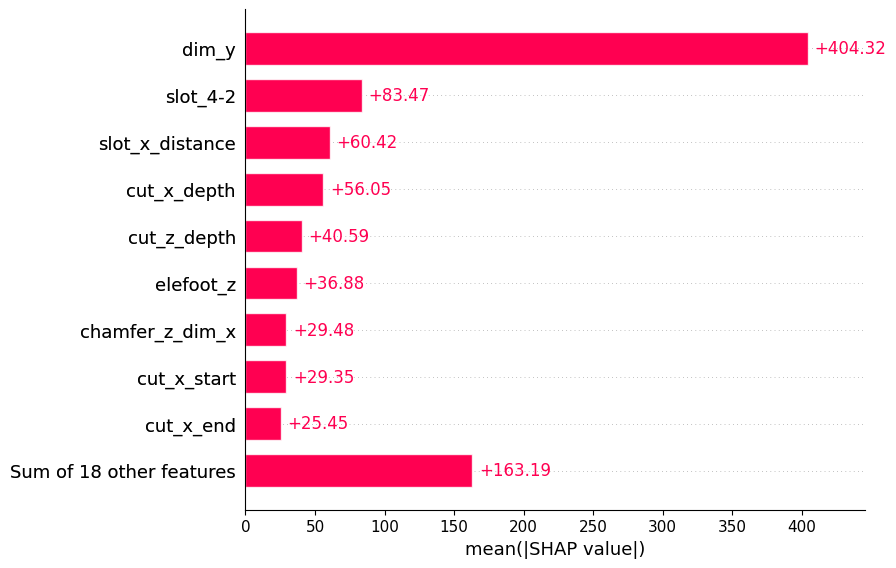

In [24]:
plt.figure(figsize=(4, 4))
shap.plots.bar(shap_values)

The beeswarm plot provides a visual summary of feature importance across multiple predictions. The vertical spread of the swarm at each feature represents the density of data points:

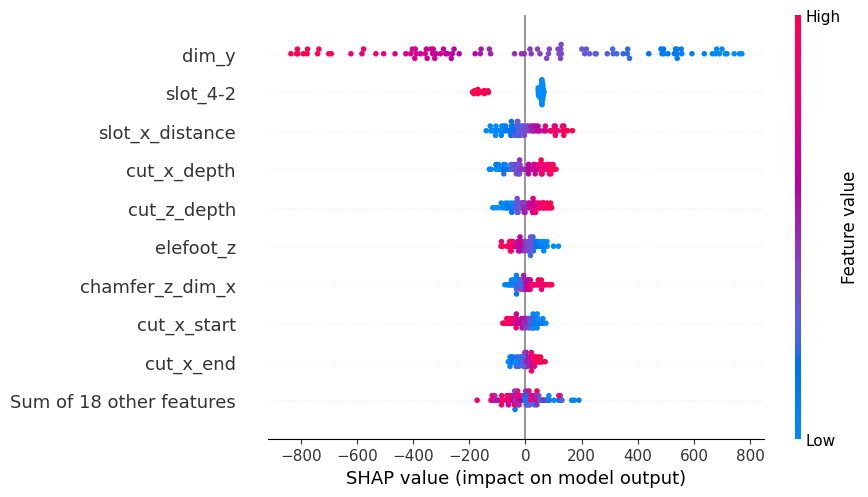

In [25]:
plt.figure(figsize=(4, 4))
shap.plots.beeswarm(shap_values)

* As the length (dim_y) value increases its SHAP value decreases (as expected)
* The second most important feature is the slot distribution class "4-2", whose values are 0 or 1. If the class is active, the longitudinal frequency is about 250 Hz lower. The effect is maximal for this slot distribution because of the number of slots is particulary important (6 slots).
* The chamfer widths and cut depths increase the frequencies since mass is removed at antinodes (points with great displacements).

## Best and worst predictions

Let's take a particular look into the best and worst predictions:

In [31]:
idx_res_max = residuals_hist_abs.idxmax()
dp_no_res_max = df_params.loc[idx_res_max, 'dp_no']
print('Design point with the greatest residual:', dp_no_res_max, '(Error =', residuals_hist_abs.max(), 'Hz)')
print('Predicted frequency:', y_pred_tuned_hist[idx_res_max], 'Hz')
print('True frequency:', y_test[idx_res_max], 'Hz')

Design point with the greatest residual: 11429 (Error = 249.0384420348455 Hz)
Predicted frequency: 20081.871557965154 Hz
True frequency: 20330.91 Hz


In [32]:
idx_res_min = residuals_hist_abs.idxmin()
dp_no_res_min = df_params.loc[idx_res_min, 'dp_no']
print('Design point with the smallest residual:', dp_no_res_min, '(Error =', residuals_hist_abs.min(), 'Hz)')
print('Predicted frequency:', y_pred_tuned_hist[idx_res_min], 'Hz')
print('True frequency:', y_test[idx_res_min], 'Hz')

Design point with the smallest residual: 10398 (Error = 0.008057316495978739 Hz)
Predicted frequency: 19681.976942683505 Hz
True frequency: 19681.985 Hz


The design point 11429 is particularly interesting because the predicted frequency is close to the center of the frequency range.

In [46]:
ft_mode_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-modes_nrdd.ft')
ft_nodes_path = os.path.join(base_dir, 'Scripts', str(fam) + '-feat-nodes.ft')
ft_defs_path = os.path.join(base_dir, 'Scripts', str(fam) + '-coll-defs.ft')

df_modes = pd.read_feather(ft_mode_path)
df_nodes = pd.read_feather(ft_nodes_path)
df_defs = pd.read_feather(ft_defs_path)

In [33]:
df_modes

,dp_no,mode_no,freq,rel_dev,mean_in_disp,mean_out_disp,mode_gain,mode_mac,freq_ratio,freq_fox_kapoor,mode_name,coupling_mac,sensitivity
0,1001,25,10876.975,234.49997,-0.012,-0.001,0.08582,0.000323,0.565980,-3.983721e-09,mode25,0.000480,1.912191e-12
1,1001,26,10933.537,13.09020,0.109,0.038,0.34644,0.000006,0.568923,-4.003396e-09,mode26,0.098223,3.932259e-10
2,1001,27,11027.669,84.30474,-0.001,0.009,6.69809,0.001305,0.573821,-4.036804e-09,mode27,0.001923,7.761451e-12
3,1001,28,11061.111,730.50937,-0.010,0.001,0.09930,0.000438,0.575561,-4.048878e-09,mode28,0.000051,2.064067e-13
4,1001,29,11170.265,625.94078,0.003,0.001,0.25063,0.000012,0.581241,-4.089054e-09,mode29,0.000078,3.193474e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607387,11999,96,27491.449,967.39541,0.001,-0.001,1.31907,0.000015,1.380392,2.784388e-09,mode96,0.000047,1.306840e-13
607388,11999,97,27520.148,245.47758,-0.001,-0.005,4.99439,0.000167,1.381833,2.772202e-09,mode97,0.000877,2.430015e-12
607389,11999,98,27581.676,422.81995,-0.002,0.004,1.66456,0.000128,1.384922,2.746389e-09,mode98,0.000209,5.741315e-13
607390,11999,99,27587.681,100.51100,0.008,0.017,2.04339,0.001967,1.385224,2.743893e-09,mode99,0.003588,9.844322e-12


In [43]:
df_modes.loc[(df_modes['dp_no'] == dp_no_res_max) & ((df_modes['mode_no'] >= 54) & (df_modes['mode_no'] < 60)), ['dp_no', 'mode_no', 'freq', 'mode_mac']]

,dp_no,mode_no,freq,mode_mac
564025,11429,54,19321.948,0.000021
564026,11429,55,19993.723,0.284323
564027,11429,56,20109.459,0.000764
564028,11429,57,20330.910,0.374686
564029,11429,58,20736.378,0.000711
564030,11429,59,20895.412,0.000064


In [54]:
def get_coordinates_displacement(dp):
    """"
    Get node coordinates and displacements for a particular design point"
    """
    
    # Get nodes and displacements of the mode
    nodes = df_nodes[df_nodes['dp_no'] == dp]
    defs = df_defs[df_defs['dp_no'] == dp]

     # Merge node coordinates and displacements
    uy_nodes = pd.merge(nodes, defs, how='inner', on='node_no', suffixes=['', '_1'])   

    return uy_nodes

def plot_2d_norm_disp(dp, mode_no, set_zlim=False):
    """
    Visualization of the displacement of the output square [-1:1] as heatmap only
    # Arguments
    dp:         design point
    mode_no:    mode number
    set_zlim:   set min z to 0
    """

    # Get frequency of the mode
    frequency = df_modes.loc[(df_modes['dp_no'] == dp) & (df_modes['mode_no'] == mode_no), 'freq'].item()

    # Column name of the displacement
    col_disp = 'mode' + str(mode_no)

    # Get nodes and displacements of the mode
    uy_nodes = get_coordinates_displacement(dp)
    px = uy_nodes['x_coord_n']
    pz = uy_nodes['z_coord_n']
    disp = np.array(uy_nodes[col_disp])
    # If the displacement is negative at the first node, reverse the displacement vector (makes sense particularly for the longitudinal mode)
    if disp[0] < 0:
        disp = -disp

    # two-dimensional interpolation with scipy.interpolate.griddata
    x = np.linspace(px.min(), px.max(), 20)
    z = np.linspace(pz.min(), pz.max(), 20)
    X, Z = np.meshgrid(x, z)
    Disp_near = griddata((px, pz), disp, (X, Z), method='nearest')
    Disp_cub = griddata((px, pz), disp, (X, Z), method='cubic')
    title = format('Design point %i\n Mode #%i (%0.0f Hz)' % (dp, mode_no, frequency))

    # 2d plot
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.axis('equal')
    cs = ax1.contourf(X, Z, Disp_cub, levels=15, cmap='jet')
    ax1.set_title(title)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Z')

    # 3d plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.axis('equal')
    ax2.plot_surface(X, Z, Disp_cub, cmap='jet', shade=True, rstride=1, cstride=1)
    ax2.set_title(title)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.set_xlim([-1.1, 1.1])
    ax2.set_ylim([-1.1, 1.1])
    if set_zlim:
        ax2.set_zlim([0, max(disp)])
    else:
        ax2.set_zlim([min(disp), max(disp)])
    plt.colorbar(cs)
    plt.show()

    return X, Z, Disp_near

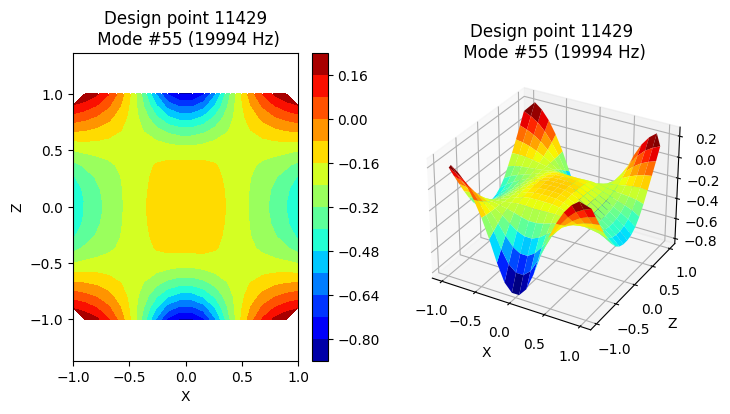

In [55]:
plot_2d_norm_disp(dp_no_res_max, 55, False);

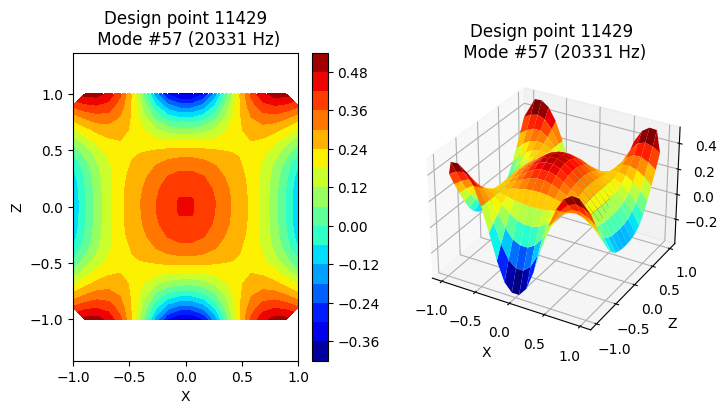

In [56]:
plot_2d_norm_disp(dp_no_res_max, 57, False);

When we look at the MAC values of the modes we can recognize that 2 modes are sharing the identification of the longitudinal mode. Even if the mode 57 has the greatest MAC value, the mode 55 located only 300 Hz below has an important longitudinal participation. In that specific case the longitudinal mode is not obviously identified and divided between 2 or more eigenvectors ("Degeneration" of the longitudinal mode). If the mode 55 has been picked as the longitudinal mode, then the residual would have been much lower.

Let's display the relationship between the residuals and the MAC values of the design points in the Test set

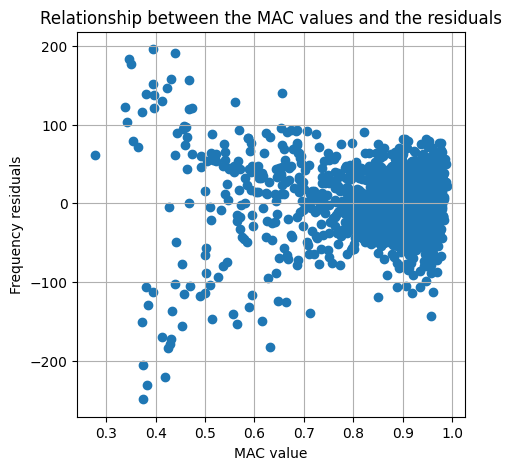

In [106]:
# Get the MAC values of the test set
idx_test = X_test.index
mac_long_test = df_params.loc[idx_test, 'mode_mac_long']

# The frequency residuals are plotted as a function of the MAC values
fig = plt.figure(figsize=(5, 5))
plt.scatter(mac_long_test, residuals_hist)
plt.xlabel('MAC value')
plt.ylabel('Frequency residuals')
plt.title('Relationship between the MAC values and the residuals')
plt.grid(True)
plt.show()

### Filter the data according the MAC values

In [67]:
print('According the results of DP 11429, the residuals are increasing drastically for poor MAC values.')
print('By filtering out all design points with low MAC values, we focus on designs with clearly identified longitudinal modes and increase the quality of the predictions at the same time.')
print('If the threshold for MAC value is set at 0.75, ', len(df_params.loc[df_params['mode_mac_long'] > 0.75])/len(df_params)*100, '% of the data will be kept for the model.')

According the results of DP 11429, the residuals are increasing drastically for poor MAC values.
By filtering out all design points with low MAC values, we focus on designs with clearly identified longitudinal modes and increase the quality of the predictions at the same time.
If the threshold for MAC value is set at 0.75,  85.20650813516896 % of the data will be kept for the model.


In [69]:
# Filter the original DataFrame
df_params_filt = df_params.loc[df_params['mode_mac_long'] > 0.75]
df_params_filt.head()

,dp_no,dim_x,dim_y,dim_z,nb_slots_x,slot_x_length,slot_x_distance,nb_slots_z,slot_z_length,slot_z_distance,...,disp_long_396,disp_long_397,disp_long_398,disp_long_399,sum_sensi,coupling_long,slot_2-2,slot_3-2,slot_4-1,slot_4-2
0,1001,175.06,121.95,240.31,4,75.993,43.235,2,78.219,59.508,...,0.170716,0.140101,0.144549,0.151599,3.405414e-16,0.960466,0,0,0,1
1,1002,173.45,122.77,238.13,4,81.168,45.859,2,78.924,57.208,...,0.167263,0.146107,0.139493,0.143682,5.401730e-17,0.956635,0,0,0,1
2,1003,175.85,116.71,238.10,4,77.532,45.260,2,80.099,49.215,...,0.293034,0.274524,0.277739,0.284010,2.678586e-18,0.986845,0,0,0,1
3,1004,173.51,116.37,238.30,4,82.428,51.007,2,74.757,50.840,...,0.242726,0.182347,0.183003,0.186770,8.933099e-18,0.967459,0,0,0,1
4,1005,175.60,118.72,241.04,4,76.576,45.981,2,78.773,64.702,...,0.260120,0.259677,0.281911,0.293833,8.025438e-18,0.991598,0,0,0,1


In [70]:
X_filt = df_params_filt[lst_expl + lst_slot_class]
y_filt = df_params_filt[target]

# New Train-Test split
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.2, random_state=55)

We fit the estimator again with the same hyperparameters as before

In [79]:
preprocessor = ColumnTransformer(
                        transformers=[
                                ('numerical', StandardScaler(), lst_expl),
                                ('categorical', 'passthrough', lst_slot_class)]                              
                        )

pipe_hist_filt = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', tuned_regressor)
                        ])

pipe_hist_filt.fit(X_train_filt, y_train_filt)
print ('Score of the new test set:', pipe_hist_filt.score(X_test_filt, y_test_filt))

Score of the new test set: 0.9956101772567219


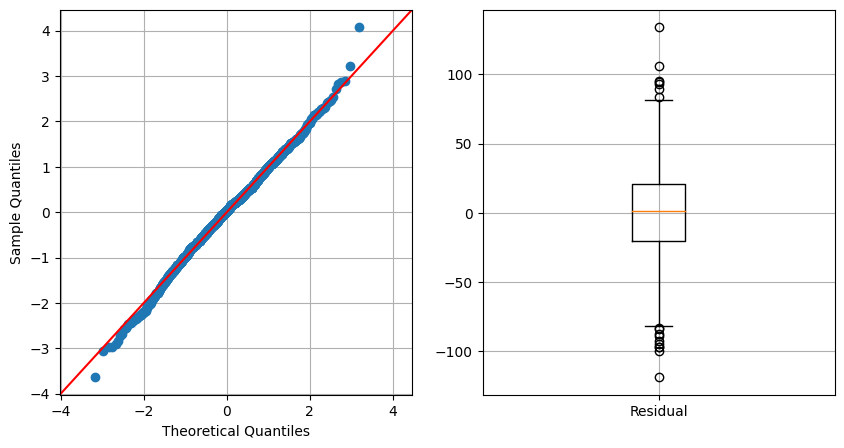

In [85]:
pipe_hist_filt.fit(X_train_filt, y_train_filt)
y_pred_hist_filt = pd.Series(pipe_hist_filt.predict(X_test_filt), index=y_test_filt.index)
residuals_hist_filt = y_pred_hist_filt-y_test_filt

# Q-Q plot of the new distribution
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sm.qqplot(residuals_hist_filt, fit=True, line='45', ax=ax)
plt.grid(True)
plt.plot

ax = fig.add_subplot(1, 2, 2)
plt.boxplot(residuals_hist_filt)
plt.xticks([1], ['Residual'], rotation=0)
plt.grid(True)

plt.show()

The distribution of the residuals with the filtered data set follows now a normal distribution and is still centered around 0. The mean absolute error (MAE) is the arithmetic average of the absolute errors (as it is scale-dependent accuracy measure, the unit is in Hz)

In [88]:
print ('Mean Absolute Error:', mean_absolute_error(y_test_filt, y_pred_hist_filt), 'Hz')

Mean Absolute Error: 25.66794635194535 Hz


The last step to confirm the presence of white noise is the test of autocorrelation. For this test, the residuals are analysed with the ACF (Autocorrelation Function):

<Figure size 400x400 with 0 Axes>

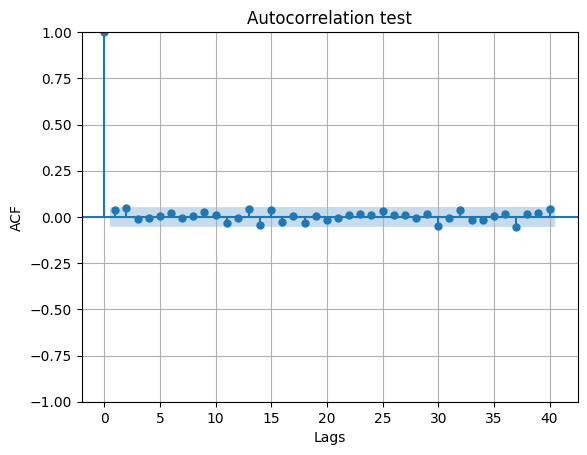

In [107]:
fig = plt.figure(figsize=(4, 4))
plot_acf(residuals_hist_filt.values, lags=40)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation test')
plt.grid(True)
plt.show()

All autocorrelation points are inside the confidence interval of 5%, the residuals can be considered as not autocorrelated. Therefore the white noise assumption is confirmed. 